In [1]:
import geopandas as gpd
import pandas as pd
import networkx as nx
import osmnx as ox
from shapely.geometry import Point
from tqdm import tqdm

In [2]:
# Load the merged walk + bike network (GraphML format)
G = ox.load_graphml("output/G_combined_final.graphml")

In [3]:
G = ox.project_graph(G, to_crs="EPSG:27700")

In [4]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 234107
Number of edges: 669464


In [5]:
# Load LSOA boundaries
lsoa = gpd.read_file("data/ESRI/LSOA_2011_London_gen_MHW.shp").to_crs(epsg=27700)

In [6]:
inner_boroughs = [
    "Camden", "Islington", "Hackney", "Tower Hamlets", "Westminster",
    "Kensington and Chelsea", "Hammersmith and Fulham", "Lambeth",
    "Southwark", "Wandsworth", "Lewisham", "Greenwich", "City of London"
]

lsoa = lsoa[lsoa["LAD11NM"].isin(inner_boroughs)].copy()

In [7]:
# Compute LSOA centroids and match to nearest network nodes
lsoa["centroid"] = lsoa.geometry.centroid

In [8]:
# Batch nearest node matching
xs = lsoa["centroid"].x.values
ys = lsoa["centroid"].y.values
lsoa["nearest_node"] = ox.distance.nearest_nodes(G, xs, ys)

In [9]:
lsoa.head()

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,centroid,nearest_node
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,0,112.9,876,1.7,"POLYGON ((532105.092 182011.23, 532162.491 181...",POINT (532150.879 181615.038),2118622487
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,0,62.9,830,1.7,"POLYGON ((532746.813 181786.891, 532671.688 18...",POINT (532443.354 181645.862),5609643658
2,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,1346,1250,96,227.7,817,1.5,"POLYGON ((532135.145 182198.119, 532158.25 182...",POINT (532207.062 182030.087),1155584130
3,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,E12000007,London,985,985,0,52.0,467,2.1,"POLYGON ((533807.946 180767.77, 533649.063 180...",POINT (533618.591 181157.118),722208263
824,E01000842,Camden 011A,E02000176,Camden 011,E09000007,Camden,E12000007,London,1444,1368,76,137.3,724,1.9,"POLYGON ((527317.841 184750.587, 527357.075 18...",POINT (527139.281 184691.924),1690247398


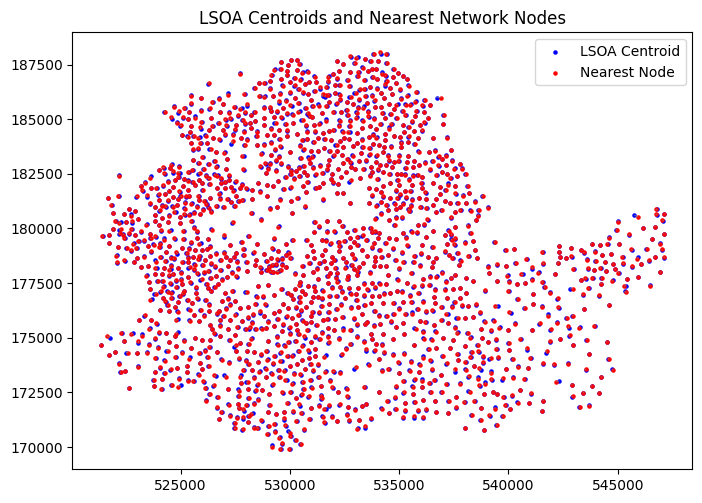

In [10]:
# Visualization

import matplotlib.pyplot as plt

nearest_nodes = lsoa["nearest_node"].apply(lambda node_id: G.nodes[node_id])
nearest_points = [Point(node["x"], node["y"]) for node in nearest_nodes]
gdf_nearest = gpd.GeoDataFrame(geometry=nearest_points, crs="EPSG:27700")

fig, ax = plt.subplots(figsize=(8, 8))

lsoa["centroid"].plot(ax=ax, color='blue', markersize=5, label="LSOA Centroid")

gdf_nearest.plot(ax=ax, color='red', markersize=5, label="Nearest Node")

for centroid, node in zip(lsoa["centroid"], gdf_nearest.geometry):
    ax.plot([centroid.x, node.x], [centroid.y, node.y], color='gray', linewidth=0.5)

ax.set_title("LSOA Centroids and Nearest Network Nodes")
ax.legend()
plt.show()

<Axes: >

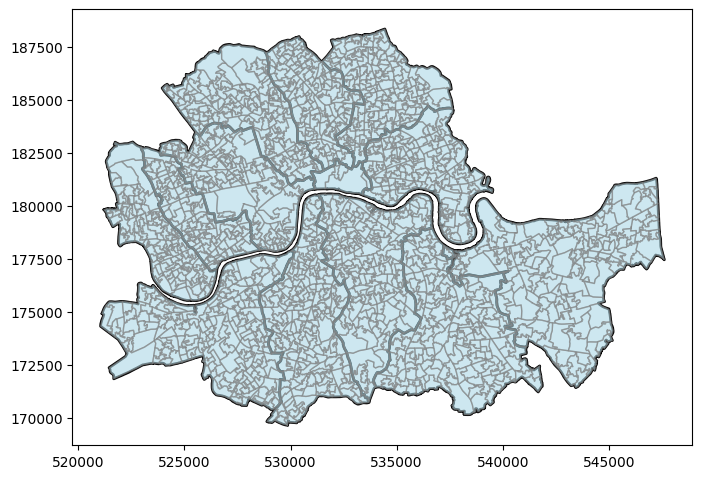

In [11]:
boroughs = gpd.read_file("data/ESRI/London_Borough_Excluding_MHW.shp").to_crs(epsg=27700)
inner_boroughs_gdf = boroughs[boroughs["NAME"].isin(inner_boroughs)]

ax = inner_boroughs_gdf.plot(edgecolor='black', facecolor='none', linewidth=2, figsize=(8, 8))
lsoa.plot(ax=ax, facecolor='lightblue', edgecolor='gray', alpha=0.6)

In [12]:
# Generate geometry column for nearest nodes
# Extract nearest node coordinates (x, y) from graph G
nearest_points = [Point(G.nodes[n]["x"], G.nodes[n]["y"]) for n in lsoa["nearest_node"]]
gdf_nearest = gpd.GeoDataFrame(geometry=nearest_points, crs="EPSG:27700")

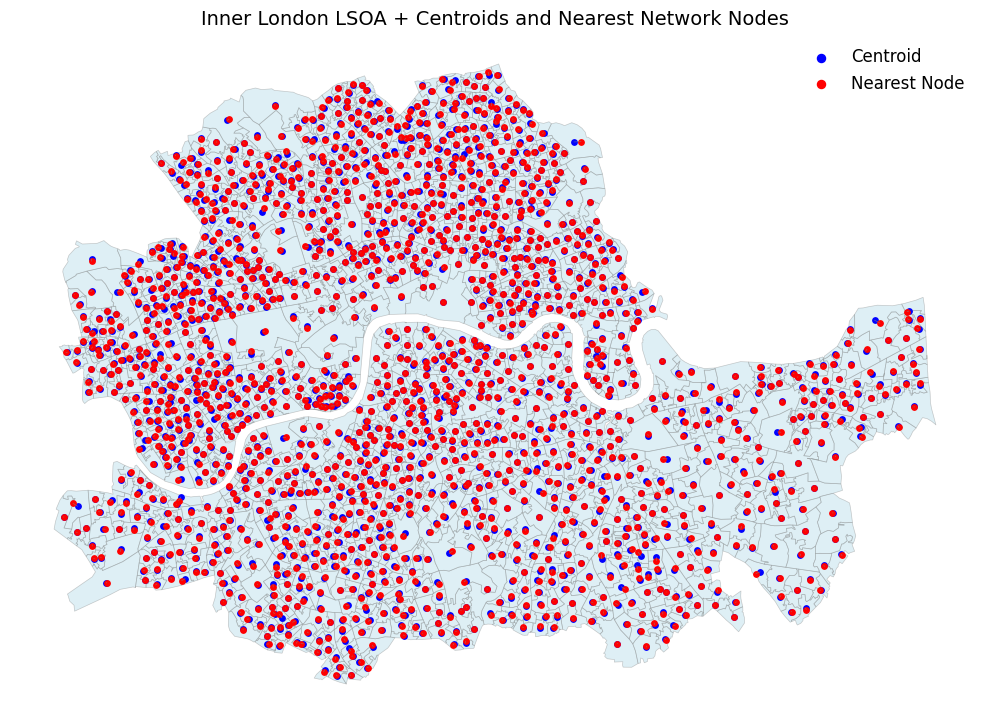

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))

lsoa.plot(ax=ax, edgecolor="gray", facecolor="lightblue", alpha=0.4, linewidth=0.5)

lsoa["centroid"].plot(ax=ax, color="blue", markersize=15, label="Centroid")

gdf_nearest.plot(ax=ax, color="red", markersize=15, label="Nearest Node")

for centroid, node_pt in zip(lsoa["centroid"], gdf_nearest.geometry):
    ax.plot([centroid.x, node_pt.x], [centroid.y, node_pt.y],
            color="gray", linewidth=0.5, alpha=0.7)

ax.set_title("Inner London LSOA + Centroids and Nearest Network Nodes", fontsize=14)

ax.axis('off')

ax.legend(loc='upper right', fontsize=12, frameon=False, markerscale=1.5)

plt.tight_layout()
plt.savefig("output/3/lsoa_centroid_nearest.png", dpi=300, bbox_inches="tight")
plt.show()


In [14]:
# Load GVI sample point data
df = pd.read_csv("output/GVI_london.csv")
df = df[df["exists"] == 1].copy()

# Convert to GeoDataFrame
gdf_samples = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")

gdf_samples = gdf_samples.to_crs(epsg=27700)

In [15]:
# Extract edges from G, keeping length and geometry
edges_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True, fill_edge_geometry=True).reset_index()
edges_gdf = edges_gdf[["u", "v", "geometry", "length"]]
edges_gdf = edges_gdf.to_crs(epsg=27700)

In [16]:
# Spatial join: match each sample point to its nearest edge (u, v)
gdf_samples = gpd.sjoin_nearest(gdf_samples, edges_gdf, how="left", distance_col="dist")
gdf_samples["edge_id"] = list(zip(gdf_samples["u"], gdf_samples["v"]))

In [17]:
# Save GVI sample points with matched edge info for later use
gdf_samples.to_csv("output/gdf_samples_with_edge.csv", index=False)

In [18]:
print(gdf_samples.head())

       filename     heading  green_1  green_2  green_3  green_4  green_5  \
0  00000000.jpg  179.072357   0.2388   0.1948   0.1777    0.429   0.3603   
0  00000000.jpg  179.072357   0.2388   0.1948   0.1777    0.429   0.3603   
0  00000000.jpg  179.072357   0.2388   0.1948   0.1777    0.429   0.3603   
0  00000000.jpg  179.072357   0.2388   0.1948   0.1777    0.429   0.3603   
0  00000000.jpg  179.072357   0.2388   0.1948   0.1777    0.429   0.3603   

   green_6  green_mean       lon        lat  exists  \
0   0.2963     0.28283 -0.145792  51.526976       1   
0   0.2963     0.28283 -0.145792  51.526976       1   
0   0.2963     0.28283 -0.145792  51.526976       1   
0   0.2963     0.28283 -0.145792  51.526976       1   
0   0.2963     0.28283 -0.145792  51.526976       1   

                        geometry  index_right         u         v      length  \
0  POINT (528723.253 182524.988)            0     78112  25508583   19.391301   
0  POINT (528723.253 182524.988)            5  255

In [19]:
# Save as GeoPackage to retain spatial info
gdf_samples.to_file("output/gdf_samples_with_edge.gpkg", layer="gvi_points", driver="GPKG")

In [20]:
# Save as GeoPackage to retain spatial info
edges_gdf["edge_id"] = edges_gdf.apply(lambda row: tuple(sorted((row["u"], row["v"]))), axis=1)
edge_length_dict = dict(zip(edges_gdf["edge_id"], edges_gdf["length"]))

import numpy as np
import pandas as pd
from tqdm import tqdm
import networkx as nx

results = []

# Preprocess: unify gdf_samples edge_id into undirected form
gdf_samples["edge_id"] = gdf_samples["edge_id"].apply(lambda x: tuple(sorted(x)))

for idx, row in tqdm(lsoa.iterrows(), total=len(lsoa)):
    source_node = row["nearest_node"]

    try:
        if source_node not in G.nodes:
            raise ValueError(f"❌ source_node {source_node} 不在图中")

        # Get 15-min reachable nodes
        lengths = nx.single_source_dijkstra_path_length(
            G, source_node, cutoff=1250, weight='length'
        )

        # Select reachable edges
        reachable_edges = []
        for u, v, d in G.edges(data=True):
            edge = tuple(sorted((u, v)))
            length = d.get("length", 9999)
            if (u in lengths and v in lengths) or ((u in lengths or v in lengths) and length <= 300):
                reachable_edges.append(edge)

        # Find sample points located on reachable edges
        points_in_range = gdf_samples[gdf_samples["edge_id"].isin(reachable_edges)]
        num_points = len(points_in_range)

        if num_points > 0:
            # Simple mean
            gvi_mean_simple = points_in_range["green_mean"].mean()

            # Length-weighted mean
            edge_means = []
            edge_lengths_for_mean = []
            for edge_id, group in points_in_range.groupby("edge_id"):
                edge_mean = group["green_mean"].mean()
                edge_means.append(edge_mean)
                edge_lengths_for_mean.append(edge_length_dict.get(edge_id, 0))

            if sum(edge_lengths_for_mean) > 0:
                gvi_mean_weighted = np.average(edge_means, weights=edge_lengths_for_mean)
            else:
                gvi_mean_weighted = None

            # Length-weighted standard deviation (correct MSD → weighted → sqrt)
            mu_lsoa = gvi_mean_weighted
            edge_msd_list = []
            edge_lengths = []

            for edge_id, group in points_in_range.groupby("edge_id"):
                vals = group["green_mean"].values
                L = edge_length_dict.get(edge_id, 0)
                if len(vals) > 0 and mu_lsoa is not None and not np.isnan(mu_lsoa):
                    msd = np.mean((vals - mu_lsoa) ** 2)  # mean squared deviation
                else:
                    msd = 0.0
                edge_msd_list.append(msd)
                edge_lengths.append(L)

            if sum(edge_lengths) > 0:
                var_len_weighted = np.average(edge_msd_list, weights=edge_lengths)
                weighted_std = np.sqrt(var_len_weighted)  # final standard deviation
                cv_lsoa = (weighted_std / mu_lsoa) if (mu_lsoa is not None and mu_lsoa > 0) else None
            else:
                weighted_std = None
                cv_lsoa = None

            gvi_std = weighted_std

        else:
            gvi_mean_simple = None
            gvi_mean_weighted = None
            gvi_std = None
            cv_lsoa = None
    
    except Exception as e:
        print(f"❌ {row['LSOA11CD']} 失败：{e}")
        gvi_mean_simple = None
        gvi_mean_weighted = None
        gvi_std = None
        cv_lsoa = None
        num_points = 0

    # Aggregate results
    results.append({
        "LSOA11CD": row["LSOA11CD"],
        "green_mean_15min_simple": gvi_mean_simple,
        "green_mean_15min_weighted": gvi_mean_weighted,
        "green_std_15min": gvi_std,
        "green_cv_15min": cv_lsoa,
        "num_samples": num_points
    })

# Save results
df_result = pd.DataFrame(results)
df_result.to_csv("output/lsoa_15min_green_gvi_with_cv_weighted.csv", index=False)
print("\n📁 CSV 已保存：output/lsoa_15min_green_gvi_with_cv_weighted.csv")



In [21]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import networkx as nx

results = []

# Preprocess: unify gdf_samples edge_id into undirected form
gdf_samples["edge_id"] = gdf_samples["edge_id"].apply(lambda x: tuple(sorted(x)))

for idx, row in tqdm(lsoa.iterrows(), total=len(lsoa)):
    source_node = row["nearest_node"]

    try:
        if source_node not in G.nodes:
            raise ValueError(f"❌ source_node {source_node} 不在图中")

        # Get 15-min reachable nodes
        lengths = nx.single_source_dijkstra_path_length(
            G, source_node, cutoff=1250, weight='length'
        )

        # Select reachable edges
        reachable_edges = []
        for u, v, d in G.edges(data=True):
            edge = tuple(sorted((u, v)))
            length = d.get("length", 9999)
            if (u in lengths and v in lengths) or ((u in lengths or v in lengths) and length <= 300):
                reachable_edges.append(edge)

        # Find sample points located on reachable edges
        points_in_range = gdf_samples[gdf_samples["edge_id"].isin(reachable_edges)]
        num_points = len(points_in_range)

        if num_points > 0:
            # Simple mean
            gvi_mean_simple = points_in_range["green_mean"].mean()

            # Length-weighted mean
            edge_means = []
            edge_lengths_for_mean = []
            for edge_id, group in points_in_range.groupby("edge_id"):
                edge_mean = group["green_mean"].mean()
                edge_means.append(edge_mean)
                edge_lengths_for_mean.append(edge_length_dict.get(edge_id, 0))

            if sum(edge_lengths_for_mean) > 0:
                gvi_mean_weighted = np.average(edge_means, weights=edge_lengths_for_mean)
            else:
                gvi_mean_weighted = None

            # Length-weighted standard deviation
            mu_lsoa = gvi_mean_weighted
            edge_msd_list = []
            edge_lengths = []

            for edge_id, group in points_in_range.groupby("edge_id"):
                vals = group["green_mean"].values
                L = edge_length_dict.get(edge_id, 0)
                if len(vals) > 0 and mu_lsoa is not None and not np.isnan(mu_lsoa):
                    msd = np.mean((vals - mu_lsoa) ** 2)  # 均方差
                else:
                    msd = 0.0
                edge_msd_list.append(msd)
                edge_lengths.append(L)

            if sum(edge_lengths) > 0:
                var_len_weighted = np.average(edge_msd_list, weights=edge_lengths)
                weighted_std = np.sqrt(var_len_weighted)  # 最终标准差
                cv_lsoa = (weighted_std / mu_lsoa) if (mu_lsoa is not None and mu_lsoa > 0) else None
            else:
                weighted_std = None
                cv_lsoa = None

            gvi_std = weighted_std

        else:
            gvi_mean_simple = None
            gvi_mean_weighted = None
            gvi_std = None
            cv_lsoa = None
    
    except Exception as e:
        print(f"❌ {row['LSOA11CD']} 失败：{e}")
        gvi_mean_simple = None
        gvi_mean_weighted = None
        gvi_std = None
        cv_lsoa = None
        num_points = 0

    # Aggregate results
    results.append({
        "LSOA11CD": row["LSOA11CD"],
        "green_mean_15min_simple": gvi_mean_simple,
        "green_mean_15min_weighted": gvi_mean_weighted,
        "green_std_15min": gvi_std,
        "green_cv_15min": cv_lsoa,
        "num_samples": num_points
    })

# Save results
df_result = pd.DataFrame(results)
df_result.to_csv("output/lsoa_15min_green_gvi_with_cv_weighted2.csv", index=False)
print("\n saved：output/lsoa_15min_green_gvi_with_cv_weighted2.csv")


100%|███████████████████████████████████████| 1737/1737 [45:10<00:00,  1.56s/it]


 saved：output/lsoa_15min_green_gvi_with_cv_weighted2.csv


In [22]:
# Calculate area
lsoa["area_m2"] = lsoa.geometry.area

# Sort by area (descending)
lsoa_area_table = lsoa[["LSOA11CD", "area_m2"]].sort_values(by="area_m2", ascending=False)

print(lsoa_area_table.head(10))


       LSOA11CD       area_m2
4569  E01004689  1.922781e+06
4461  E01004573  1.677023e+06
4674  E01032739  1.658496e+06
895   E01000913  1.609173e+06
1633  E01001667  1.359872e+06
1830  E01001877  1.275870e+06
1610  E01001642  1.193824e+06
4615  E01004736  1.192057e+06
1649  E01001684  1.176790e+06
4606  E01004727  1.131600e+06


## 挑选几个展示

In [23]:
# Reload previously saved results
df_result = pd.read_csv("output/lsoa_15min_green_gvi_with_cv_weighted2.csv")

In [24]:
# Filter LSOAs where num_samples < 2000
sample_ids = df_result[df_result["num_samples"] < 2000]["LSOA11CD"].tolist()
# Filter LSOAs where num_samples < 3000
sample_ids2 = df_result[df_result["num_samples"] < 3000]["LSOA11CD"].tolist()

In [25]:
import matplotlib.pyplot as plt

def plot_lsoa_network_coverage(lsoa_row, G, edges_gdf, buffer_radius=1250):
    lsoa_id = lsoa_row["LSOA11CD"]
    source_node = lsoa_row["nearest_node"]
    centroid = lsoa_row["centroid"]

    # Run Dijkstra to get reachable nodes (node → distance)
    lengths = nx.single_source_dijkstra_path_length(G, source_node, cutoff=buffer_radius, weight='length')
    reachable_nodes = set(lengths.keys())

    # Identify edges within reach
    reachable_edges = []
    for u, v, d in G.edges(data=True):
        if u in reachable_nodes and v in reachable_nodes:
            reachable_edges.append((u, v))
        elif (u in reachable_nodes or v in reachable_nodes) and d.get("length", 9999) <= 300:
            reachable_edges.append((u, v))

    # Extract geometry of these edges (from edges_gdf)
    reachable_edges_set = set(reachable_edges)
    gdf_selected_edges = edges_gdf[edges_gdf[["u", "v"]].apply(tuple, axis=1).isin(reachable_edges_set)]

    # Plot
    fig, ax = plt.subplots(figsize=(8, 8))

    # LSOA centroid
    gpd.GeoSeries(centroid).plot(ax=ax, color="blue", markersize=20, label="LSOA Centroid")

    gpd.GeoSeries(lsoa_row["geometry"]).plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2, label="LSOA Boundary")

    # Reachable roads
    gdf_selected_edges.plot(ax=ax, color="#C71585", linewidth=1, label="Reachable Edges (≤15 min)")

    ax.set_title(f"LSOA {lsoa_id} – 15 min Reachable Road Network")
    ax.legend()
    ax.set_aspect("equal") 
    return fig 


In [26]:
# Visualize LSOAs with fewer than 2000 sampling points to check network coverage

import os
os.makedirs("output/lsoa_samples_less_2000", exist_ok=True)

for lsoa_id in sample_ids:
    row = lsoa[lsoa["LSOA11CD"] == lsoa_id].iloc[0]
    fig = plot_lsoa_network_coverage(row, G, edges_gdf)
    fig.savefig(f"output/lsoa_samples_less_2000/{lsoa_id}.png", bbox_inches="tight")
    plt.close(fig) 

/var/folders/1b/rnlsjn413cqc2z980tkgfp2w0000gn/T/ipykernel_46426/3958634909.py:36: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/var/folders/1b/rnlsjn413cqc2z980tkgfp2w0000gn/T/ipykernel_46426/3958634909.py:36: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/var/folders/1b/rnlsjn413cqc2z980tkgfp2w0000gn/T/ipykernel_46426/3958634909.py:36: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/var/folders/1b/rnlsjn413cqc2z980tkgfp2w0000gn/T/ipykernel_46426/3958634909.py:36: UserWarning: Legend does not support handles for PatchColle

/var/folders/1b/rnlsjn413cqc2z980tkgfp2w0000gn/T/ipykernel_46426/1460617019.py:26: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


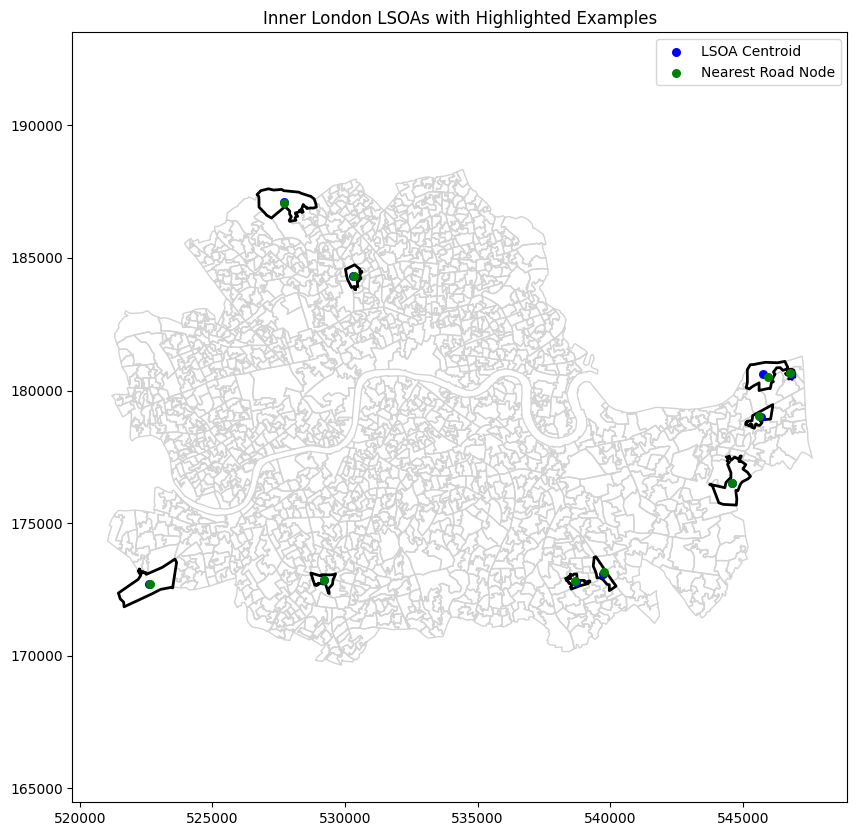

In [28]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Visualize Inner London LSOAs with fewer than 2000 sampling points, showing centroids and nearest road nodes
highlighted = lsoa[lsoa["LSOA11CD"].isin(sample_ids)].copy()

base_lsoas = lsoa.copy()

highlighted_centroids = gpd.GeoSeries(highlighted["centroid"], crs=lsoa.crs)
highlighted_nodes = gpd.GeoSeries(
    highlighted["nearest_node"].apply(lambda nid: Point((G.nodes[nid]["x"], G.nodes[nid]["y"]))),
    crs=lsoa.crs
)

fig, ax = plt.subplots(figsize=(10, 10))

base_lsoas.plot(ax=ax, edgecolor="lightgray", facecolor="none", linewidth=1)

highlighted.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=2, label="Highlighted LSOAs")

highlighted_centroids.plot(ax=ax, color="blue", markersize=30, label="LSOA Centroid")

highlighted_nodes.plot(ax=ax, color="green", markersize=30, label="Nearest Road Node")

ax.legend()
ax.set_title("Inner London LSOAs with Highlighted Examples")
ax.axis("equal")
plt.show()

/var/folders/1b/rnlsjn413cqc2z980tkgfp2w0000gn/T/ipykernel_46426/2408399104.py:66: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


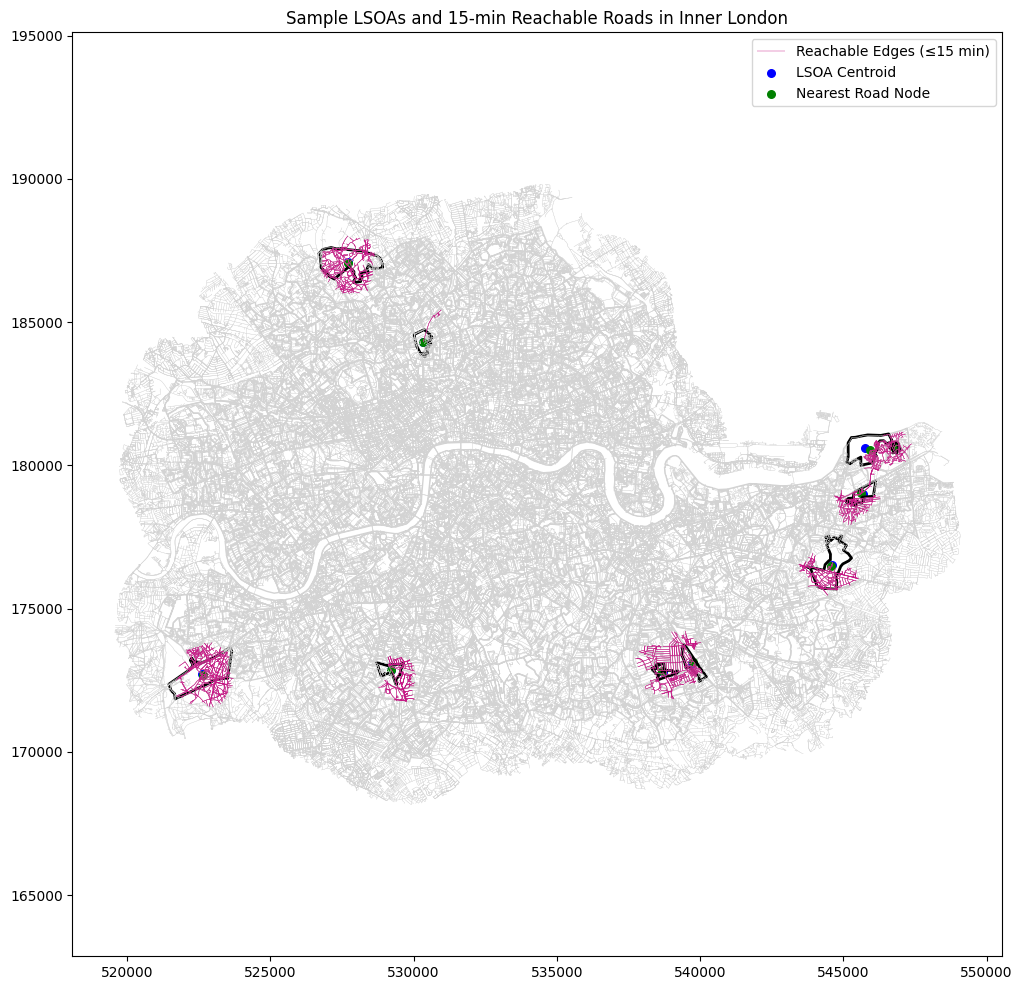

In [29]:
# Sample LSOAs and 15-min Reachable Roads in Inner London
highlighted = lsoa[lsoa["LSOA11CD"].isin(sample_ids)].copy()
base_lsoas = lsoa.copy()


highlighted_centroids = gpd.GeoSeries(highlighted["centroid"], crs=lsoa.crs)
highlighted_nodes = gpd.GeoSeries(
    highlighted["nearest_node"].apply(lambda nid: Point((G.nodes[nid]["x"], G.nodes[nid]["y"]))),
    crs=lsoa.crs
)

all_edges = edges_gdf.copy()

from networkx.algorithms.shortest_paths.weighted import single_source_dijkstra_path_length

def get_reachable_edges(lsoa_row, G, buffer_radius=1250):
    source_node = lsoa_row["nearest_node"]
    lengths = nx.single_source_dijkstra_path_length(G, source_node, cutoff=buffer_radius, weight='length')
    reachable_nodes = set(lengths.keys())
    reachable_edges = []

    for u, v, d in G.edges(data=True):
        if u in reachable_nodes and v in reachable_nodes:
            reachable_edges.append((u, v))
        elif (u in reachable_nodes or v in reachable_nodes) and d.get("length", 9999) <= 300:
            reachable_edges.append((u, v))

    return reachable_edges

reachable_edges_all = set()
for _, row in highlighted.iterrows():
    reachable_edges_all.update(get_reachable_edges(row, G))

reachable_edges_df = edges_gdf[
    edges_gdf[["u", "v"]].apply(tuple, axis=1).isin(reachable_edges_all)
]

fig, ax = plt.subplots(figsize=(12, 12))

base_lsoas.plot(ax=ax, edgecolor="lightgray", facecolor="none", linewidth=1)

all_edges.plot(ax=ax, color="lightgray", linewidth=0.2

reachable_edges_df.plot(ax=ax, color="#C71585", linewidth=0.3, label="Reachable Edges (≤15 min)")

highlighted_centroids.plot(ax=ax, color="blue", markersize=30, label="LSOA Centroid")
               
highlighted_nodes.plot(ax=ax, color="green", markersize=30, label="Nearest Road Node")

highlighted.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=2, label="Highlighted LSOAs")

ax.set_title("Sample LSOAs and 15-min Reachable Roads in Inner London")
ax.legend()
ax.axis("equal")
plt.show()

## Display all one by one

In [30]:
import matplotlib.pyplot as plt
import os
from tqdm import tqdm


lsoa["area"] = lsoa.geometry.area

os.makedirs("output/lsoa_plots", exist_ok=True)

def plot_single_lsoa(lsoa_row, G, edges_gdf, buffer_radius=1250):
    lsoa_id = lsoa_row["LSOA11CD"]
    source_node = lsoa_row["nearest_node"]
    centroid = lsoa_row["centroid"]
    
    lengths = nx.single_source_dijkstra_path_length(G, source_node, cutoff=buffer_radius, weight='length')
    reachable_nodes = set(lengths.keys())
    
    reachable_edges = []
    for u, v, d in G.edges(data=True):
        if u in reachable_nodes and v in reachable_nodes:
            reachable_edges.append((u, v))
        elif (u in reachable_nodes or v in reachable_nodes) and d.get("length", 9999) <= 300:
            reachable_edges.append((u, v))
    reachable_edges_set = set(reachable_edges)
    
    selected_edges = edges_gdf[edges_gdf[["u", "v"]].apply(tuple, axis=1).isin(reachable_edges_set)]
    
    fig, ax = plt.subplots(figsize=(6, 6))
    selected_edges.plot(ax=ax, color="#C71585", linewidth=0.8)
    gpd.GeoSeries(lsoa_row["geometry"]).plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2)
    gpd.GeoSeries(centroid).plot(ax=ax, color="blue", markersize=15)
    
    ax.set_title(f"{lsoa_id} - 15 min Network")
    ax.axis("off")
    
    plt.savefig(f"output/lsoa_plots/{lsoa_id}.png", bbox_inches="tight")
    plt.close()

# Select LSOAs with larger areas (e.g., top 80)
lsoa_large = lsoa.sort_values("area", ascending=False).head(80)

for _, row in tqdm(lsoa_large.iterrows(), total=len(lsoa_large)):
    plot_single_lsoa(row, G, edges_gdf)


100%|███████████████████████████████████████████| 80/80 [04:56<00:00,  3.70s/it]


/var/folders/1b/rnlsjn413cqc2z980tkgfp2w0000gn/T/ipykernel_46426/24897667.py:58: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


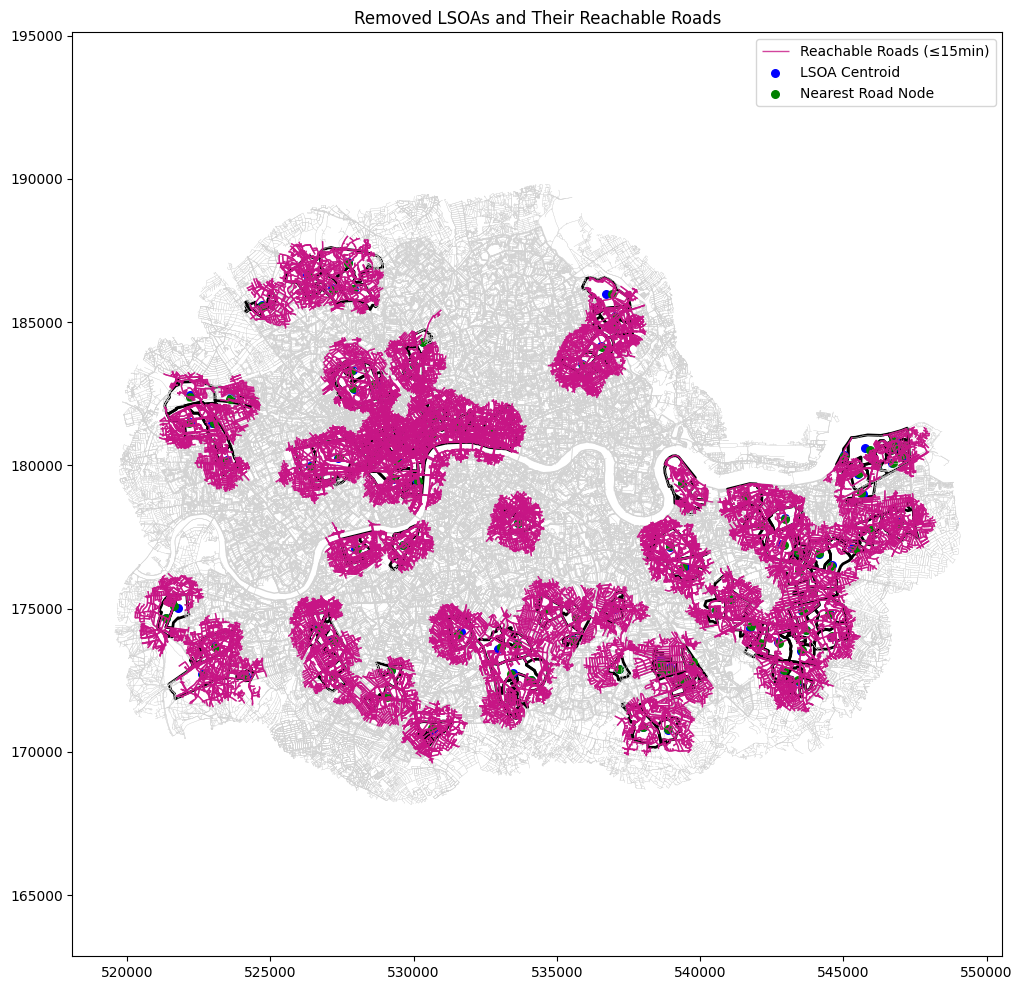

In [31]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from networkx.algorithms.shortest_paths.weighted import single_source_dijkstra_path_length

# Display the 80 largest LSOAs on the map along with their 15-minute road networks


large_lsoa_ids = lsoa_large.head(80)["LSOA11CD"].tolist()

removed_ids = list(set(sample_ids2) | set(large_lsoa_ids))

highlighted = lsoa[lsoa["LSOA11CD"].isin(removed_ids)].copy()
base_lsoas = lsoa.copy()

highlighted_centroids = gpd.GeoSeries(highlighted["centroid"], crs=lsoa.crs)
highlighted_nodes = gpd.GeoSeries(
    highlighted["nearest_node"].apply(lambda nid: Point((G.nodes[nid]["x"], G.nodes[nid]["y"]))),
    crs=lsoa.crs
)

def get_reachable_edges(lsoa_row, G, buffer_radius=1250):
    source_node = lsoa_row["nearest_node"]
    lengths = single_source_dijkstra_path_length(G, source_node, cutoff=buffer_radius, weight='length')
    reachable_nodes = set(lengths.keys())

    reachable_edges = []
    for u, v, d in G.edges(data=True):
        if u in reachable_nodes and v in reachable_nodes:
            reachable_edges.append((u, v))
        elif (u in reachable_nodes or v in reachable_nodes) and d.get("length", 9999) <= 300:
            reachable_edges.append((u, v))

    return reachable_edges

reachable_edges_all = set()
for _, row in highlighted.iterrows():
    reachable_edges_all.update(get_reachable_edges(row, G))

reachable_edges_gdf = edges_gdf[
    edges_gdf[["u", "v"]].apply(tuple, axis=1).isin(reachable_edges_all)
]

fig, ax = plt.subplots(figsize=(12, 12))

base_lsoas.plot(ax=ax, edgecolor="lightgray", facecolor="none", linewidth=1)

edges_gdf.plot(ax=ax, color="lightgray", linewidth=0.2)

reachable_edges_gdf.plot(ax=ax, color="#C71585", linewidth=1, alpha=0.8, label="Reachable Roads (≤15min)")

highlighted.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=2, label="Removed LSOAs")

highlighted_centroids.plot(ax=ax, color="blue", markersize=30, label="LSOA Centroid")

highlighted_nodes.plot(ax=ax, color="green", markersize=30, label="Nearest Road Node")

ax.legend()
ax.set_title("Removed LSOAs and Their Reachable Roads")
ax.axis("equal")
plt.show()

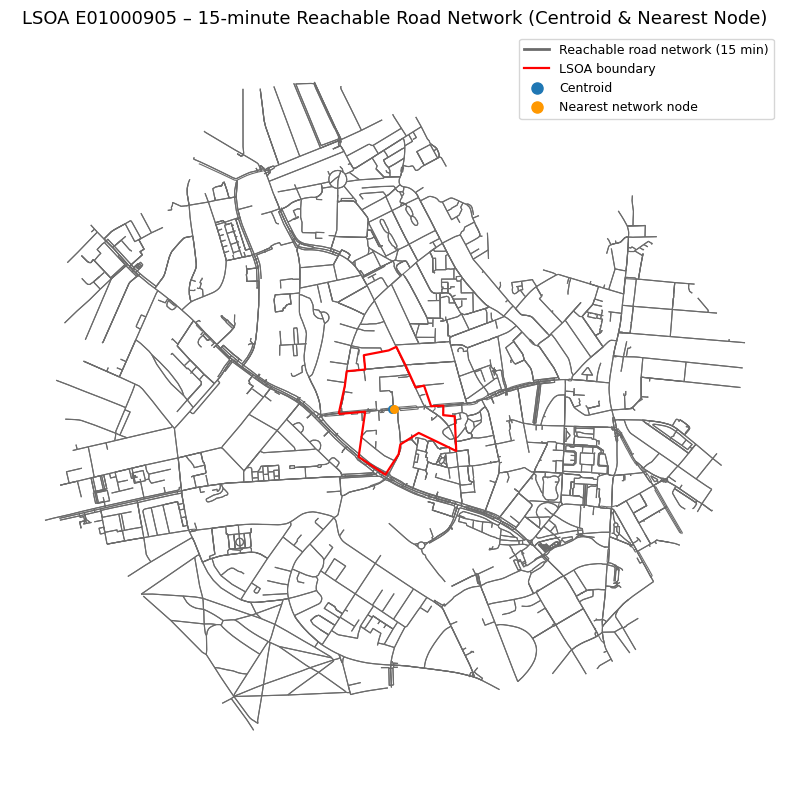

Saved: output/3/E01000905_network.png


In [33]:
import os
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd
import networkx as nx

# visualization
TARGET_ID = "E01000905"
BUFFER_RADIUS = 1250  # 15-min ~ 1.25 km


ROAD_COLOR = "#6b6b6b"  
ROAD_WIDTH = 0.8        
BOUNDARY_COLOR = "red"  
BOUNDARY_WIDTH = 1.6
CENTROID_COLOR = "#1f77b4"  
NEAREST_COLOR  = "#ff9800"  

os.makedirs("output/3", exist_ok=True)

# Select the target LSOA
row = lsoa.loc[lsoa["LSOA11CD"] == TARGET_ID].iloc[0]
source_node = row["nearest_node"]
centroid = row["centroid"]
lsoa_geom = row["geometry"]

# Compute 15-minute reachable edges
lengths = nx.single_source_dijkstra_path_length(G, source_node,
                                                cutoff=BUFFER_RADIUS, weight="length")
reachable_nodes = set(lengths.keys())

reachable_edges = []
for u, v, d in G.edges(data=True):
    if u in reachable_nodes and v in reachable_nodes:
        reachable_edges.append((u, v))
    elif (u in reachable_nodes or v in reachable_nodes) and d.get("length", 9999) <= 300:
        reachable_edges.append((u, v))
reachable_edges_set = set(reachable_edges)

gdf_selected_edges = edges_gdf[edges_gdf[["u", "v"]]
                               .apply(tuple, axis=1).isin(reachable_edges_set)]

#  Nearest network node and centroid
nearest_pt = Point(G.nodes[source_node]["x"], G.nodes[source_node]["y"])
gdf_centroid   = gpd.GeoSeries([centroid], crs="EPSG:27700")
gdf_nearest_pt = gpd.GeoSeries([nearest_pt], crs="EPSG:27700")
gdf_boundary   = gpd.GeoSeries([lsoa_geom], crs="EPSG:27700")

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))

# Road network (base layer)
gdf_selected_edges.plot(ax=ax, color=ROAD_COLOR, linewidth=ROAD_WIDTH, zorder=1)

# LSOA boundary
gdf_boundary.boundary.plot(ax=ax, color=BOUNDARY_COLOR, linewidth=BOUNDARY_WIDTH, zorder=2)

# Centroid and nearest node
gdf_centroid.plot(ax=ax, color=CENTROID_COLOR, markersize=30, zorder=3)
gdf_nearest_pt.plot(ax=ax, color=NEAREST_COLOR, markersize=30, zorder=4)


ax.set_title(f"LSOA {TARGET_ID} – 15-minute Reachable Road Network (Centroid & Nearest Node)",
             fontsize=13)
ax.axis("equal")
ax.axis("off")

legend_handles = [
    Line2D([0],[0], color=ROAD_COLOR, lw=2, label="Reachable road network (15 min)"),
    Line2D([0],[0], color=BOUNDARY_COLOR, lw=BOUNDARY_WIDTH, label="LSOA boundary"),
    Line2D([0],[0], marker='o', linestyle='None', markersize=8, color=CENTROID_COLOR, label="Centroid"),
    Line2D([0],[0], marker='o', linestyle='None', markersize=8, color=NEAREST_COLOR,  label="Nearest network node"),
]
ax.legend(handles=legend_handles, loc="upper right", fontsize=9, frameon=True)

# save
out_path = "output/3/E01000905_network.png"
plt.tight_layout()
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved: {out_path}")


In [34]:
# 15-minute Reachable Road Network of LSOA {lsoa_id}
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# Output directory
output_dir = "output/lsoa_network_maps"
os.makedirs(output_dir, exist_ok=True)

# All LSOA IDs
sample_ids = list(lsoa["LSOA11CD"].unique())

# Function to save LSOA network map
def save_lsoa_network_map(lsoa_row, G, edges_gdf, buffer_radius=1250):
    lsoa_id = lsoa_row["LSOA11CD"]
    source_node = lsoa_row["nearest_node"]
    centroid = lsoa_row["centroid"]

    lengths = nx.single_source_dijkstra_path_length(G, source_node, cutoff=buffer_radius, weight="length")
    reachable_nodes = set(lengths.keys())

    reachable_edges = []
    for u, v, d in G.edges(data=True):
        if u in reachable_nodes and v in reachable_nodes:
            reachable_edges.append((u, v))
        elif (u in reachable_nodes or v in reachable_nodes) and d.get("length", 9999) <= 300:
            reachable_edges.append((u, v))

    reachable_edges_set = set(reachable_edges)
    gdf_selected_edges = edges_gdf[edges_gdf[["u", "v"]].apply(tuple, axis=1).isin(reachable_edges_set)]

    fig, ax = plt.subplots(figsize=(8, 8))
    gdf_selected_edges.plot(ax=ax, color="#C71585", linewidth=1)
    gpd.GeoSeries(lsoa_row["geometry"]).plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2)
    gpd.GeoSeries(centroid).plot(ax=ax, color="blue", markersize=20)
    ax.set_title(f"LSOA {lsoa_id} – 15 min Reachable Road Network")
    ax.axis("equal")
    ax.axis("off")
    plt.savefig(os.path.join(output_dir, f"{lsoa_id}.png"), dpi=150, bbox_inches="tight")
    plt.close()

# Batch save with progress bar
for lsoa_id in tqdm(sample_ids, desc="Saving LSOA maps"):
    row = lsoa[lsoa["LSOA11CD"] == lsoa_id].iloc[0]
    save_lsoa_network_map(row, G, edges_gdf)

print("All LSOA maps saved!")


Saving LSOA maps: 100%|███████████████████| 1737/1737 [1:54:35<00:00,  3.96s/it]

All LSOA maps saved!
